# Photocurrent in $Al_x Ga_{1-x} As/GaAs$ quantum heterostructures


In [2]:
# python standard
import time

# load libraries and set plot parameters
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 14, 12
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"

import scipy.constants as cte
from scipy.signal import gaussian
from scipy.special import legendre
from scipy.sparse import diags
from scipy.linalg import inv
from scipy.integrate import simps
from scipy.optimize import newton
from scipy.interpolate import interp1d
from scipy.spatial.distance import cdist

# constants
au_l   = cte.value('atomic unit of length')
au_t   = cte.value('atomic unit of time')
au_e   = cte.value('atomic unit of energy')
ev     = cte.value('electron volt')
au2ang = au_l / 1e-10
au2ev  = au_e / ev

## Parameters

In [3]:
B      = 50
N      = 1024 #2048
#z_ang  = np.linspace(-250.0, 250.0, N) # Angstrom
z_ang  = np.geomspace(-250.0,-125.0,B,endpoint=False)
z_ang  = np.append(z_ang, np.linspace(-125.0,125.0, N-2*B, endpoint=False))
z_ang  = np.append(z_ang, np.geomspace(125.0,250.0, B))
z_au   = z_ang / au2ang
# plt.scatter(np.linspace(0,N,N),z_ang)
# plt.show()

## Bound States

In [4]:
def orthonormal(n=2, size=2048):
    """
    Return the first `n` orthonormal legendre polynoms weighted by a gaussian
    They are useful as kickstart arrays for a imaginary time evolution

    Params
    ------
    n : int
        The number of arrays
    size : int
        The number of points in each array
    """
    sg  = np.linspace(-1, 1, size) # short grid
    g   = gaussian(size, std=int(size/100)) # gaussian
    vls = [g*legendre(i)(sg) for i in range(n)]
    return np.array(vls, dtype=np.complex_)


def fi(v, i):
    """
    short for flex_index, find the index `i` in array `v`
    `i` might be float, so that for `i = 1.5`, the return would be
    `(v[2]+v[1])/2`
    
    Params
    ------
    v : array_like
        a list of real or complex numbers
    i : int
        a semi integer number between 0 and the vector's `v` length
    """
    if i < 0.0:
        return v[0]
    elif i >= len(v) - 1:
        return v[-1]
    
    try:
        i_up   = int(np.ceil(i))
        i_down = int(np.floor(i))
        return (v[i_up]+v[i_down])/2.0
    except:
        return 0.0
    
def eigenvalue(z, V, psi, m):
    """
    calculate eigenvalue like E=<Psi|H|Psi>/<Psi|Psi>
    where H = T + `V`, T is the only kinect operator in one dimension
    
    Params
    ------
    z : array_like
        the coordinates grid
    V : array_like
        the potential
    psi : array_like
        the wave function
    m : array_like
        the (position dependent) effective mass
    """
    #dz    = z[1]-z[0]
    dz    = np.append(z[1:]-z[:-1], z[1]-z[0])
    dz2   = dz**2
    h_psi = np.zeros(N, dtype=np.complex_)
    
    for i in range(N):
        h_psi[i] = ((0.5/dz2[i])*(1.0/fi(m,i+0.5)+1.0/fi(m,i-0.5))+V[i])*psi[i]
        
        if i > 0:
            h_psi[i] += -(0.5/dz2[i])*(psi[i-1]/fi(m,i-0.5))
            
        if i < N-1:
            h_psi[i] += -(0.5/dz2[i])*(psi[i+1]/fi(m,i+0.5))
            
    psi_h_psi = simps(psi.conj()*h_psi, z)
    return (psi_h_psi / simps(psi.conj()*psi, z)).real
    
    
def bound_states(z, V, m, nmax=20, precision=1e-9):
    """
    find the bound eigenstates for a given potential `V` under the effective
    mass approximation (`m`)
    
    Params
    ------
    z : array_like
        the coordinates grid
    V : array_like
        the potential
    m : array_like
        the (position dependent) effective mass
    nmax : int
        since it uses the inverse interaction, it is the max number of
        kick start eigenvalues in a grid between `min(V)` and `max(V)`
    precision : float
        it is the max error allowed for each eigenvalue, the error is just
        (new_eigenalue_n - old_eigenalue_n)/old_eigenalue_n
    """
    
    forecast = np.linspace(np.min(V), np.max(V), nmax)
#     dz  = z[1]-z[0]
    dz    = np.append(z[1:]-z[:-1], z[1]-z[0])
    dz2 = dz**2
    
    # kick start eigenstates
    eigenstates = orthonormal(nmax, size=N)
#     ks = orthonormal(2*nmax, size=N)
#     eigenstates = np.array([ks[i]+ks[i+1] for i in range(0, 2*nmax, 2)])
    eigenvalues = np.zeros(nmax)
    
    # matrix diagonals
    sub_diag  = np.zeros(N-1, dtype=np.complex_)
    main_diag = np.zeros(N  , dtype=np.complex_)

    def get_invA(v_shift=0.0):
        """Applies a shift in the potential, same as H'=H-beta """
        for i in range(N):
            try:
                main_diag[i] = (0.5/dz2[i])*(1.0/fi(m,i+0.5)+1.0/fi(m,i-0.5)) \
                    +(V[i]-v_shift)
            except:
                main_diag[i] = 0.0

            if i < N-1:
                sub_diag[i] = -(0.5/dz2[i])*(1.0/fi(m,i+0.5))

        diagonals = [main_diag, sub_diag, sub_diag]
        A         = diags(diagonals, [0, -1, 1]).toarray()
        return inv(A)
            
    counters = np.zeros(nmax)
    timers = np.zeros(nmax)
    precisions = np.zeros(nmax)
    vectors_sqeuclidean = np.zeros(nmax)
    
    for s in range(nmax):
        last_ev = 1.0
        last_es = np.zeros(N, dtype=np.complex_)
        
        shift = forecast[s]
        invA = get_invA(shift)
        V_shifted = V-shift
        
        while True:
            start_time = time.time()
            eigenstates[s] = invA.dot(eigenstates[s])
            counters[s] += 1

#             # gram-shimdt
#             for j in range(s):
#                 proj = simps(eigenstates[s]*eigenstates[j].conj(), z)
#                 eigenstates[s] -= proj * eigenstates[j]

            # normalize
            A = np.sqrt(simps(eigenstates[s]*eigenstates[s].conj(), z))
            eigenstates[s] /= A
            timers[s] += time.time() - start_time

            eigenvalues[s] = eigenvalue(z,V_shifted,eigenstates[s],m)+shift

            # check precision
            precisions[s] = np.abs(1-eigenvalues[s]/last_ev)
            last_ev = eigenvalues[s]

            if precisions[s] < precision:
                XA = [np.abs(eigenstates[s])**2]
                XB = [np.abs(last_es)**2]
                vectors_sqeuclidean[s] = cdist(XA, XB, 'sqeuclidean')[0][0]
                break

            last_es = np.copy(eigenstates[s])
    
    def get_break(a, x, n=10):
        """ finds where de deriative of the array a changes more than 5% """
        der_a = np.array(a[2:]-a[:-2])/np.array(x[2:]-x[:-2])
        for i in range(n, len(der_a)):
            last_n  = np.average(der_a[i-n:i-1])
            if last_n == 0 and der_a[i] != 0 \
                or last_n != 0 and np.abs(der_a[i]/last_n-1) > 0.05:
                return i
        return int(len(a)/3)
    
    sort_index  = eigenvalues.argsort()
    eigenvalues = eigenvalues[sort_index]
    eigenstates = eigenstates[sort_index]
    
    iz_left     = get_break(V, z)
    iz_right    = len(V)-get_break(V[::-1], z)
    golden_ones = [0]
    
    for i, value in enumerate(eigenvalues):
        # drop repeated and unbounded states
        if i == 0 or np.abs(eigenvalues[i]/eigenvalues[i-1]-1) < 0.1 \
            or eigenvalues[i] > np.max(V):
            continue
        
        # drop not confined states
        state     = eigenstates[i].copy()
        state_l   = state[:iz_left]
        state_m   = state[iz_left:iz_right]
        state_r   = state[iz_right:]
        int_left  = simps(state_l*state_l.conj(), z[:iz_left]).real
        int_mid   = simps(state_m*state_m.conj(), z[iz_left:iz_right]).real
        int_right = simps(state_r*state_r.conj(), z[iz_right:]).real
        
        if int_left+int_right > int_mid:
            continue
        
        golden_ones.append(i)
        
    return {
        'eigenvalues': eigenvalues[golden_ones],
        'eigenstates': eigenstates[golden_ones],
        'counters': counters[golden_ones],
        'timers': timers[golden_ones],
        'precisions': precisions[golden_ones],
        'squared_euclidean_dist': vectors_sqeuclidean[golden_ones]
    }

#     return {
#         'eigenvalues': eigenvalues,
#         'eigenstates': eigenstates,
#         'counters': counters,
#         'timers': timers,
#         'precisions': precisions,
#         'squared_euclidean_dist': vectors_sqeuclidean
#     }

## Double Barrier Quantum Well

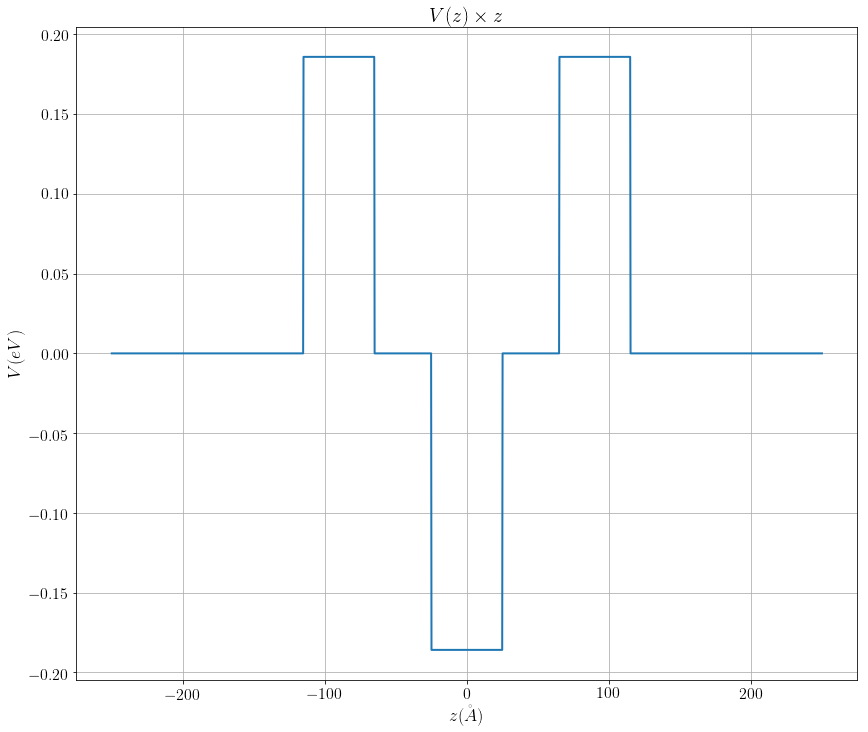

In [7]:
#g_algaas = lambda x: 1.519+1.447*x-0.15*x**2 # GAP
# Degani's actual potential
g_algaas = lambda x: 0.0 if x == 0.2 else (0.185897 if x == 0.4 else -0.185897)
m_algaas = lambda x: 0.067 + 0.083 * x # effective mass

xd       = 0.2 # displacement
xb       = 0.4 # barrier
xw       = 0.0 # well
wl       = 50.0 # Angstrom
bl       = 50.0 # Angstrom
dl       = 40.0 # Angstrom
CBO      = 0.655
VBO      = 0.345

def x_shape(z):
    if np.abs(z) < wl/2:
        return xw
    elif np.abs(z) < wl/2+dl:
        return xd
    elif np.abs(z) < wl/2+dl+bl:
        return xb
    return xd

V        = np.vectorize(lambda z: g_algaas(x_shape(z)))(z_ang)#*CBO
V       -= g_algaas(xd)#*CBO
#meff     = np.vectorize(lambda z: m_algaas(x_shape(z)))(z_ang)
# Degani's actual effective mass
meff     = np.vectorize(lambda z: m_algaas(xw))(z_ang)

fig, ax = plt.subplots()
ax.set_xlabel(r'$z (\AA)$')
ax.set_ylabel(r'$V (eV)$')
ax.plot(z_ang, V)
ax.set_title(r"$V(z) \times z$")
ax.grid(True)
plt.show()

## Potential and Coordinates grid in atomic units

In [8]:
V_au = V / au2ev
z_au = z_ang / au2ang

## Eigenvalues

In [9]:
res = bound_states(z_au, V_au, meff)
for i, eigenvalue in enumerate(res['eigenvalues']):
    value  = eigenvalue * au2ev # in eV
    print(r"E_%02d = %.8f eV" % (i, value))

E_00 = -0.11260124 eV
E_01 = 0.04043811 eV
E_02 = 0.13418340 eV


## Eigenstates

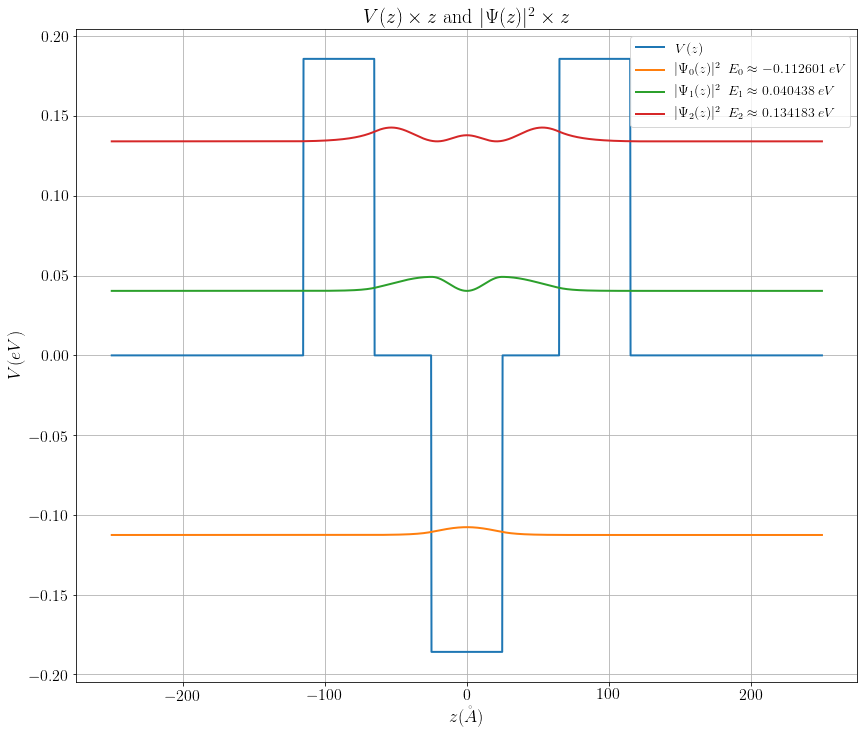

In [11]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$z (\AA)$')
ax.set_ylabel(r'$V (eV)$')
ax.plot(z_ang, V, label=r'$V(z)$')

eigenstates = res['eigenstates'].copy()
for i, eigenstate in enumerate(eigenstates):
    eigenstate *= np.ptp(V) / np.ptp(np.abs(eigenstate)**2)/50.0
    _eivenvalue = res['eigenvalues'][i]* au2ev
    psi = (np.abs(eigenstate)**2).real + _eivenvalue
    ax.plot(z_ang, psi, label=r'$|\Psi_%d(z)|^2 \,\,\, E_%d \approx %.6f \,\, eV$' % (i, i, _eivenvalue))

ax.set_title(r"$V(z) \times z$ and $|\Psi(z)|^2 \times z$")
ax.grid(True)
ax.legend()
plt.show()